# Snowtornado

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics.pairwise import cosine_similarity
from stock_exchange import create_interval_tree
from validation import train_test_split, evaluate_model

In [2]:
products = pd.read_csv("data/products.csv", dtype=str, index_col="id")
matches = pd.read_csv("data/matches.csv", index_col=False, usecols=[0, 1, 2], names=['original_id', 'replacement_id', 'timestamp'])
matches['timestamp'] = pd.to_datetime(matches['timestamp'])
stock_exchange = create_interval_tree("data/stock_exchange.csv")

Clean data by converting every field to lowercase, stripping, and finally converting it to a category type

In [3]:
binary = pd.DataFrame()

for column in products.columns:
    if not column in ["name"]:
        binary[column] = products[column].str.lower().str.strip().astype('category')
    
binary = pd.get_dummies(binary, dummy_na=True)
binary = binary.loc[:, (binary != 0).any(axis=0)] # Remove superfluous NaN columns
binary.shape

(7397, 653)

In [4]:
matches_train, matches_test = train_test_split(matches, 0.9, stock_exchange)
matches_test = matches_test.drop_duplicates(['original_id', 'replacement_id'])

Fill training data with the binary data

In [5]:
X_train = np.zeros((matches_train.shape[0], binary.shape[1]), dtype = 'bool')
X_test = np.zeros((matches_test.shape[0], binary.shape[1]), dtype = 'bool')
Y_train = np.zeros((matches_train.shape[0], binary.shape[1]), dtype = 'bool')
Y_test = np.zeros((matches_test.shape[0], binary.shape[1]), dtype = 'bool')

In [6]:
i = 0
for _, row in matches_train.iterrows():
    original_id = row['original_id']
    replacement_id = row['replacement_id']
    X_train[i] = binary.loc[[original_id]].values[0]
    Y_train[i] = binary.loc[[replacement_id]].values[0]
    i += 1

i = 0
for _, row in matches_test.iterrows():
    original_id = row['original_id']
    replacement_id = row['replacement_id']
    X_test[i] = binary.loc[[original_id]].values[0]
    Y_test[i] = binary.loc[[replacement_id]].values[0]
    i += 1

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

neurons = X_train.shape[1]

model = Sequential([
    Dense(input_dim=neurons, units=neurons, activation='relu'),
    Dense(input_dim=neurons, units=neurons, activation='relu'),
    Dense(units=neurons, activation='sigmoid'),
])
model.compile(loss='cosine_proximity', optimizer='adagrad')
model.fit(X_train, Y_train, epochs=10, batch_size=32)
#model.evaluate(X_test, Y_test, batch_size=32)

Epoch 1/10
4079/4079 [==============================] - 2s - loss: -0.0013          

In [13]:
def products_on_the_market(timestamp):
    return binary.loc[set(map((lambda x: x.data), stock_exchange[timestamp]))]

def find_matches(original_id, timestamp, limit = 3):
    prediction = model.predict(binary.loc[[original_id]].values)
    similar = cosine_similarity(prediction, products_on_the_market(timestamp))[0]
    indices = np.argpartition(similar, -limit)
    indices = indices[np.argsort(similar[indices])][::-1]
    return products_on_the_market(timestamp).index.values[indices]

def find_all_matches(original_id, timestamp):
    prediction = model.predict(binary.loc[[original_id]].values)
    similar = cosine_similarity(prediction, products_on_the_market(timestamp))[0]
    indices = np.argsort(-similar)
    return products_on_the_market(timestamp).index.values[indices].tolist()

7.9% less than 1
17.4% less than 3
23.0% less than 5
45.4% less than 15


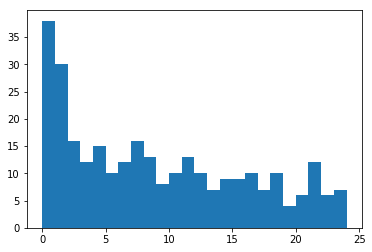

In [14]:
import matplotlib.pyplot as plt

#from IPython.display import display, HTML
#pd.options.display.max_columns = 100
#from itertools import islice
#from datetime import datetime

#for result in islice(ev, 10):
#    original_id = result[0]
#    replacement_id = result[1]
#    match = result[2]
#    position = result[3]
    
#    display(products.loc[[original_id, replacement_id, match]])

def less_than_percentage(xs, v):
    return '{:.{prec}f}% less than {}'.format(len([x for x in xs if x < v]) / len(xs) * 100, v, prec=1);

def output_evaluation(matches_test, find_all_matches):
    ev = evaluate_model(matches_test, find_all_matches)

    positions = list(map(lambda x: x[3], ev))

    print(less_than_percentage(positions, 1))
    print(less_than_percentage(positions, 3))
    print(less_than_percentage(positions, 5))
    print(less_than_percentage(positions, 15))

    plt.hist(positions, bins=range(0, 25, 1))
    #plt.hist(positions, bins=np.logspace(0, np.log10(max(positions)), 15))
    #plt.gca().set_xscale("log")
    plt.show()
    
output_evaluation(matches_test, find_all_matches)